In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [118]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, cross_val_score
from sklearn import datasets
from sklearn.preprocessing import StandardScaler

tf.__version__

'2.1.0'

In [90]:
# datasets
X_digits = np.load('./digits_pixels.npy')
y_digits = to_categorical(np.load('./digits_target.npy'))
irri = pd.read_csv('./irrigation_machine.csv', index_col=0)
dots = pd.read_csv('./dots.csv')

# Learning curves

## Learning the digits

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits,
                                                    stratify=y_digits,
                                                    test_size=0.3,
                                                    random_state=42)

In [16]:
# model for digits datasets (from sklearn)

# define model
model = Sequential()

model.add(Dense(16, input_shape=(64,), activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# test if model is well assemble by predicting before training
print(model.predict(X_train)[0, :])

[2.0713748e-01 2.2672784e-06 1.4393814e-06 1.8832165e-07 1.2499966e-05
 5.2661009e-05 7.9273015e-01 3.4845863e-05 8.4084779e-12 2.8316224e-05]


## Is the model overfitting?

In [17]:
# train and plot loss
history = model.fit(X_train, y_train,
                    epochs=60,
                    validation_data=(X_test, y_test),
                    verbose=0)

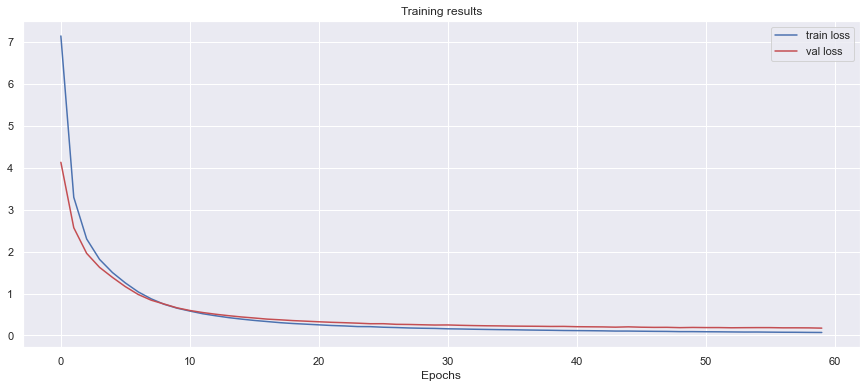

In [19]:
fig, ax = plt.subplots(figsize=(15, 6))

ax.plot(history.history['loss'], 'b', label='train loss')
ax.plot(history.history['val_loss'], 'r', label='val loss')
ax.set(title='Training results',
       xlabel='Epochs')

plt.legend()
plt.show()

## Do we need more data?

In [34]:
# initialize necessary variables
model = Sequential()

model.add(Dense(16, input_shape=(64,), activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

initial_weights = model.get_weights()

training_sizes = np.array([125, 502, 879, 1255])

early_stop = EarlyStopping(monitor='loss',
                           patience=1)

train_accs = []
test_accs = []

In [35]:
# train model at different training sizes
for size in training_sizes:
    # get portion of training data
    X_train_frac, y_train_frac = X_train[:size], y_train[:size]
    
    # reset model to initial weights and train
    model.set_weights(initial_weights)
    model.fit(X_train_frac, y_train_frac,
              epochs=50,
              callbacks=[early_stop],
              verbose=0)
    
    # evaluate and store to lists
    train_accs.append(model.evaluate(X_train, y_train)[1])
    test_accs.append(model.evaluate(X_test, y_test)[1])

540/540 [==============================] - 0s 135us/sample - loss: 0.2223 - accuracy: 0.9352


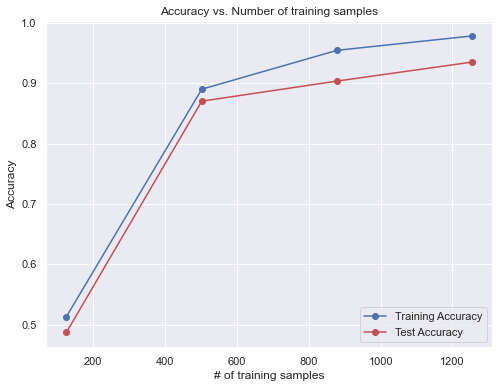

In [39]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(training_sizes, train_accs, 'b-o', label='Training Accuracy')
ax.plot(training_sizes, test_accs, 'r-o', label='Test Accuracy')
ax.set(title='Accuracy vs. Number of training samples',
       xlabel='# of training samples',
       ylabel='Accuracy')

plt.legend(loc='lower right')
plt.show()

The results shows that your model would not benefit a lot from more training data, since the test set accuracy is already starting to flatten

# Activation functions

## Comparing activation functions

In [43]:
def get_model(fxn):
    model = Sequential()
    
    model.add(Dense(64, input_shape=(20,), activation=fxn))
    model.add(Dense(3, activation='sigmoid'))
    
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [55]:
X = irri.drop(['parcel_0', 'parcel_1', 'parcel_2'], axis=1).to_numpy(float)
y = irri[['parcel_0', 'parcel_1', 'parcel_2']].to_numpy(int)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=42)

In [62]:
# activation fxns to try
activations = ['relu', tf.nn.leaky_relu, 'sigmoid', 'tanh']

# loop over fxns
activation_results = {}

for act in activations:
    # Get a new model with the current activation
    model = get_model(act)
    # Fit the model and store the history results
    h_callback = model.fit(X_train, y_train, 
                           epochs=100, 
                           validation_data=(X_test, y_test), 
                           verbose=0)
    activation_results[act] = h_callback

In [68]:
val_loss_per_function = {'relu': activation_results['relu'].history['val_loss'],
                         'leaky_relu': activation_results[tf.nn.leaky_relu].history['val_loss'],
                         'sigmoid': activation_results['sigmoid'].history['val_loss'],
                         'tanh': activation_results['tanh'].history['val_loss']}

val_acc_per_function = {'relu': activation_results['relu'].history['val_accuracy'],
                         'leaky_relu': activation_results[tf.nn.leaky_relu].history['val_accuracy'],
                         'sigmoid': activation_results['sigmoid'].history['val_accuracy'],
                         'tanh': activation_results['tanh'].history['val_accuracy']}

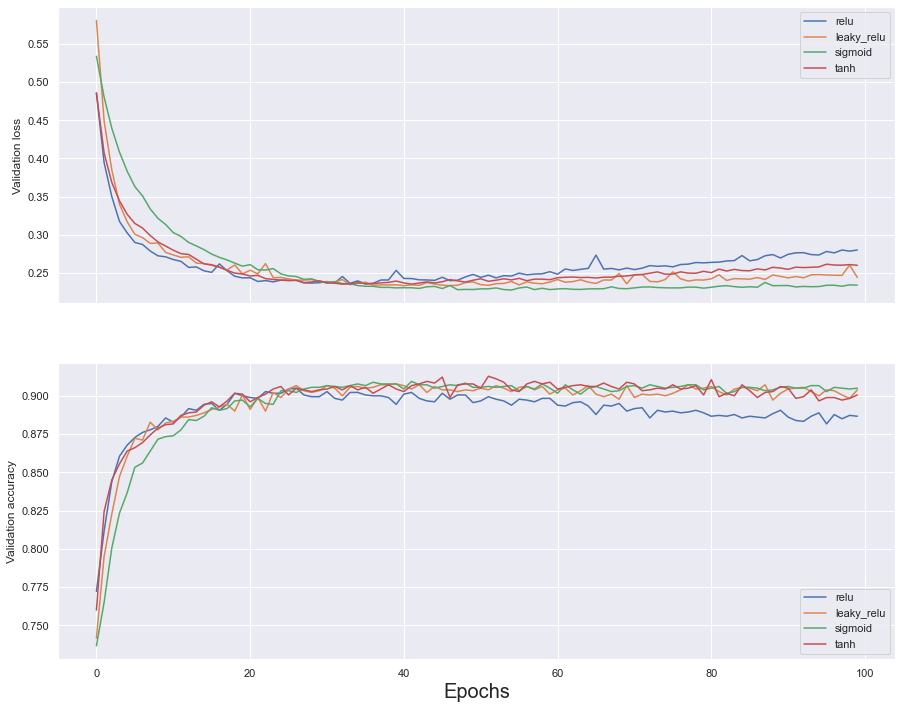

In [75]:
# Create a dataframe from val_loss_per_function
val_loss= pd.DataFrame(val_loss_per_function)

# Create a dataframe from val_acc_per_function
val_acc = pd.DataFrame(val_acc_per_function)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12),
                               sharex=True)

val_loss.plot(ax=ax1)
val_acc.plot(ax=ax2)
ax1.set(ylabel='Validation loss')
ax2.set(ylabel='Validation accuracy')

plt.xlabel('Epochs', fontsize=20)
plt.show()

# Batch size and batch normalization

## Changing batch sizes

In [78]:
print(dots.shape)
dots.head()

(1000, 3)


,0,1,2
0,0.242655,0.038320,1
1,0.044330,-0.056673,1
2,-0.786777,-0.757186,0
3,0.004067,0.131172,1
4,-0.164107,0.150650,1


In [82]:
X_dots = dots[['0', '1']].to_numpy(float)
y_dots = dots['2'].to_numpy(int)

X_train_dots, X_test_dots, y_train_dots, y_test_dots = train_test_split(X_dots, y_dots,
                                                                        test_size=0.3,
                                                                        stratify=y_dots,
                                                                        random_state=42)

In [87]:
# define model
model = Sequential()

model.add(Dense(4, input_shape=(2,), activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# train with a batch size of 1
model.fit(X_train_dots, y_train_dots,
          epochs=5,
          batch_size=1,
          verbose=0)

print(f'test acc: {model.evaluate(X_test_dots, y_test_dots)[1]: .1%}')

300/300 [==============================] - 0s 502us/sample - loss: 0.5119 - accuracy: 0.8367
test acc:  83.7%


In [88]:
# define model
model = Sequential()

model.add(Dense(4, input_shape=(2,), activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# train with a batch size of whole training data
model.fit(X_train_dots, y_train_dots,
          epochs=5,
          batch_size=X_train_dots.shape[0],
          verbose=0)

print(f'test acc: {model.evaluate(X_test_dots, y_test_dots)[1]: .1%}')

300/300 [==============================] - 0s 415us/sample - loss: 0.6645 - accuracy: 0.5333
test acc:  53.3%


You can see that accuracy is lower when using a batch size equal to the training set size. This is not because the network had more trouble learning the optimization function: Even though the same number of epochs were used for both batch sizes the number of resulting weight updates was very different!. With a batch of size the training set and 5 epochs we only get 5 updates total, each update computes and averaged gradient descent with all the training set observations. To obtain similar results with this batch size we should increase the number of epochs so that more weight updates take place.

## Batch normalizing a familiar model

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits,
                                                    stratify=y_digits,
                                                    test_size=0.3,
                                                    random_state=42)

In [94]:
# define model
batchnorm_model = Sequential()
batchnorm_model.add(Dense(50, input_shape=(64,), activation='relu', kernel_initializer='normal'))
batchnorm_model.add(BatchNormalization())
batchnorm_model.add(Dense(50, activation='relu', kernel_initializer='normal'))
batchnorm_model.add(BatchNormalization())
batchnorm_model.add(Dense(50, activation='relu', kernel_initializer='normal'))
batchnorm_model.add(BatchNormalization())
batchnorm_model.add(Dense(10, activation='softmax', kernel_initializer='normal'))

# Compile your model with sgd
batchnorm_model.compile(optimizer='sgd', 
                        loss='categorical_crossentropy', 
                        metrics=['accuracy'])

In [96]:
# define one without batchnorm
standard_model = Sequential()
standard_model.add(Dense(50, input_shape=(64,), activation='relu', kernel_initializer='normal'))
standard_model.add(Dense(50, activation='relu', kernel_initializer='normal'))
standard_model.add(Dense(50, activation='relu', kernel_initializer='normal'))
standard_model.add(Dense(10, activation='softmax', kernel_initializer='normal'))

# Compile your model with sgd
standard_model.compile(optimizer='sgd', 
                        loss='categorical_crossentropy', 
                        metrics=['accuracy'])

## Batch normalization effects

In [98]:
# Train your standard model, storing its history callback
h1_callback = standard_model.fit(X_train, y_train, 
                                 validation_data=(X_test, y_test),
                                 epochs=10, 
                                 verbose=0)

# Train the batch normalized model you recently built, store its history callback
h2_callback = batchnorm_model.fit(X_train, y_train,
                                  validation_data=(X_test, y_test),
                                  epochs=10, 
                                  verbose=0)

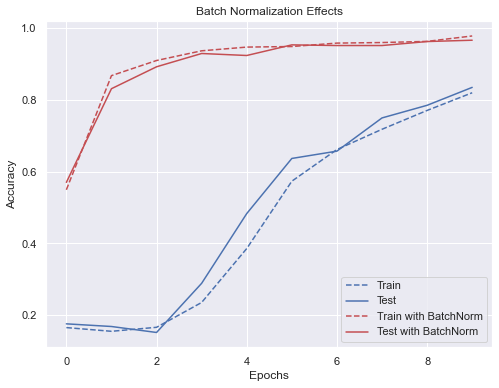

In [100]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(h1_callback.history['accuracy'], 'b--', label='Train')
ax.plot(h1_callback.history['val_accuracy'], 'b', label='Test')
ax.plot(h2_callback.history['accuracy'], 'r--', label='Train with BatchNorm')
ax.plot(h2_callback.history['val_accuracy'], 'r', label='Test with BatchNorm')

ax.set(title='Batch Normalization Effects',
       xlabel='Epochs',
       ylabel='Accuracy')

plt.legend()
plt.show()

You can see that for this deep model batch normalization proved to be useful, helping the model obtain high accuracy values just over the first 10 training epochs.

# Hyperparameter tuning

## Preparing a model for tuning

In [102]:
# function that creates a model given an activation and learning rate
def create_model(learning_rate, activation):
    # create Adam optimizer with given learning rate
    opt = Adam(lr=learning_rate)
    
    # create binary classification model
    model = Sequential()
    model.add(Dense(128, input_shape=(30,), activation=activation))
    model.add(Dense(256, activation=activation))
    model.add(Dense(1, activation='sigmoid'))
    
    # compile
    model.compile(optimizer=opt,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

## Tuning the model parameters

In [110]:
# load breast cancer
X_b, y_b = datasets.load_breast_cancer(return_X_y=True)

s = StandardScaler()
X_b = s.fit_transform(X_b)

In [116]:
# create a KerasClassifier
model = KerasClassifier(build_fn=create_model)

# define the param grid/dist
params = {'activation': ['relu', 'tanh'],
          'batch_size': [32, 128, 56],
          'epochs': [50, 100, 200],
          'learning_rate': [0.1, 0.01, 0.001]}

# create random searcg obj
random_search = RandomizedSearchCV(estimator=model,
                                   param_distributions=params,
                                   cv = KFold(3))

# fit
random_search.fit(X_b, y_b, verbose=0)

189/189 [==============================] - 0s 606us/sample - loss: 1.3092 - accuracy: 0.9577


RandomizedSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=False),
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x00000172050600C8>,
                   param_distributions={'activation': ['relu', 'tanh'],
                                        'batch_size': [32, 128, 56],
                                        'epochs': [50, 100, 200],
                                        'learning_rate': [0.1, 0.01, 0.001]})

In [117]:
print(f'Best score ({random_search.best_score_: .1%}) was achieved using these params:\n{random_search.best_params_}')

Best score ( 97.4%) was achieved using these params:
{'learning_rate': 0.001, 'epochs': 200, 'batch_size': 56, 'activation': 'relu'}


## Training with cross-validation

In [121]:
# now let's do cv with the best params
model = KerasClassifier(build_fn=create_model,
                        learning_rate=0.001,
                        epochs=200,
                        activation='relu',
                        batch_size=56,
                        verbose=0)

cv_results = cross_val_score(model, X_b, y_b, cv=3)

print(f'Mean accuracy:{cv_results.mean(): .1%}\n with standard deviation of {cv_results.std(): .3f}')

Mean accuracy: 97.0%
 with standard deviation of  0.009
